In [1]:
import pymc as pm
import arviz as az

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as pt

from thesis_tools.models.frequentist import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Generalised Pareto

In [2]:
# Define the groups and years
groups = ['Group A', 'Group B', 'Group C']

# Define the years for each group, ensuring partial overlap and no gaps within each group
group_years = {
    'Group A': list(range(2000, 2010)),  # 2000-2005
    'Group B': list(range(2003, 2012)),  # 2003-2008
    'Group C': list(range(2007, 2019))   # 2007-2011
}

# Create a list of dictionaries to construct the dataframe
data = []
for group, years in group_years.items():
    for year in years:
        data.append({'group': group, 'year': year})

# Create the dataframe
df = pd.DataFrame(data)

# Set a seed for reproducibility
np.random.seed(42)

# Generate random normal values for x_1, x_2, and x_3
df['x_1'] = np.random.normal(size=len(df))
df['x_2'] = np.random.normal(size=len(df))
df['x_3'] = np.random.normal(size=len(df))

# # Generate random beta coefficients for each group and each covariate
# beta_x_1 = {group: np.random.normal() for group in groups}
# beta_x_2 = {group: np.random.normal() for group in groups}
# beta_x_3 = {group: np.random.normal() for group in groups}
# make the betas -1, 0, 1
beta_x_1 = {group: 1.0 for group in groups}
beta_x_2 = {group: 0.0 for group in groups}
beta_x_3 = {group: -1.0 for group in groups}


# Add beta coefficients to the dataframe
df['beta_x_1'] = df['group'].map(beta_x_1)
df['beta_x_2'] = df['group'].map(beta_x_2)
df['beta_x_3'] = df['group'].map(beta_x_3)

# Add the sigma column
df['sigma'] = 0.0
for group in groups:
    min_year_index = df[df['group'] == group]['year'].idxmin()
    df.at[min_year_index, 'sigma'] = 1.0

df['log_sigma'] = np.log(df['sigma'])

# Apply the recursion formula
for group in groups:
    group_df = df[df['group'] == group]
    for i in range(1, len(group_df)):
        current_index = group_df.index[i]
        previous_index = group_df.index[i-1]
        log_sigma_t = df.at[previous_index, 'log_sigma']
        x_beta = (df.at[current_index, 'x_1'] * df.at[current_index, 'beta_x_1'] +
                  df.at[current_index, 'x_2'] * df.at[current_index, 'beta_x_2'] +
                  df.at[current_index, 'x_3'] * df.at[current_index, 'beta_x_3'])
        df.at[current_index, 'log_sigma'] = log_sigma_t + x_beta

df['sigma'] = np.exp(df['log_sigma'])

# Generate a vector of random normals with mean 0 and std sigma for each row
def generate_random_normals(row):
    sample_size = np.random.randint(50, 101)  # Random sample size between 50 and 100
    sigma = row['sigma']  # Convert log_sigma back to sigma
    return GeneralisedPareto(mu=1.0, gamma=0.25, sigma=sigma).sample(sample_size)

df['random_normals'] = df.apply(generate_random_normals, axis=1)

/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
import pandas as pd
import numpy as np

# Assuming df is the dataframe we generated previously
# Create the generalized Pareto model
generalised_pareto_model = pm.Model()

with generalised_pareto_model:
    # Define initial sigma for each group
    initial_sigma = {}
    for group in df['group'].unique():
        initial_sigma[group] = pm.Gamma(f'initial_sigma_{group}', alpha=1, beta=1)

    # Define betas for each covariate and each group
    betas = {}
    n_groups = len(df['group'].unique())
    n_covariates = 3 # TODO: Remove hardcoding
    
    betas = {}
    for cov in range(n_covariates):
        beta_variances = pm.Gamma(f'beta_variances_{cov}', alpha=1, beta=1, shape=n_groups)
        beta_cov = pt.diag(beta_variances)

        beta_mu = np.zeros(n_groups)
        betas[cov] = pm.MvNormal(f'betas_{cov}', mu=beta_mu, cov=beta_cov, shape=n_groups)

    # Prepare betas for each group
    group_betas = {group: [] for group in df['group'].unique()}
    for i, group in enumerate(df['group'].unique()):
        for cov in range(n_covariates):
            group_betas[group].append(betas[cov][i])
        group_betas[group] = pt.stack(group_betas[group])

    # Define sigma for each time step and group
    sigma = {group: [initial_sigma[group]] for group in df['group'].unique()}

    for group in df['group'].unique():
        group_df = df[df['group'] == group].reset_index()
        T = len(group_df)
        X = group_df[['x_1', 'x_2', 'x_3']].values
        
        for t in range(1, T):
            sigma[group].append(sigma[group][-1] * pm.math.exp(pm.math.dot(X[t], group_betas[group])))

    # Functions for the custom distribution
    def gpd_logp(value, mu, gamma, sigma):
        if gamma == 0:
            return -np.log(sigma) - (value - mu) / sigma
        else:
            return -np.log(sigma) - (1 + 1 / gamma) * np.log(1 + gamma * (value - mu) / sigma)

    def gpd_random(mu, gamma, sigma, rng=None, size=None):
        # generate uniforms
        u = rng.uniform(size=size)
        if gamma == 0:
            return mu - sigma * np.log(1-u)
        else:
            return mu + sigma * ((1 / (1 - u)**gamma - 1)) / gamma
        
    gammas = {}
    for group in df['group'].unique():
        gammas[group] = pm.Gamma(f'gamma_{group}', alpha=1, beta=1)
    
    mu=1.0

    y_obs = []
    for group in df['group'].unique():
        group_df = df[df['group'] == group].reset_index()
        T = len(group_df)
        for t in range(T):
            y_obs.append(pm.CustomDist(
                f'y_{group}_{t}',
                mu,
                gammas[group],
                sigma[group][t],
                logp=gpd_logp, 
                random=gpd_random,
                observed=group_df.loc[t, 'random_normals'],
            ))

In [4]:
with generalised_pareto_model:
    generalised_pareto_trace = pm.sample(1000, tune=1000, nuts_sampler='nutpie')

/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:379: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:379: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:379: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:379: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/philipphocker/Documents/G

In [9]:
az.summary(generalised_pareto_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_variances_0[0],1.264,0.939,0.102,2.963,0.013,0.011,7960.0,2961.0,1.00
beta_variances_0[1],1.208,0.939,0.121,2.892,0.012,0.011,10138.0,3056.0,1.00
beta_variances_0[2],1.222,0.942,0.100,2.879,0.013,0.012,8753.0,2791.0,1.00
beta_variances_0_log__[0],-0.012,0.721,-1.410,1.262,0.008,0.013,7960.0,2961.0,1.00
beta_variances_0_log__[1],-0.080,0.751,-1.435,1.318,0.008,0.013,10138.0,3056.0,1.00
beta_variances_0_log__[2],-0.066,0.748,-1.388,1.312,0.008,0.013,8753.0,2791.0,1.00
beta_variances_1[0],0.540,0.700,0.000,1.739,0.009,0.008,4141.0,2235.0,1.00
beta_variances_1[1],0.553,0.716,0.000,1.940,0.010,0.008,4855.0,2323.0,1.00
beta_variances_1[2],0.551,0.729,0.000,1.813,0.010,0.008,5065.0,2402.0,1.00
beta_variances_1_log__[0],-1.561,1.693,-4.843,1.101,0.032,0.029,4141.0,2235.0,1.00


In [10]:
df

,group,year,x_1,x_2,x_3,beta_x_1,beta_x_2,beta_x_3,sigma,log_sigma,random_normals
0,Group A,2000,0.496714,1.852278,-1.106335,1.0,0.0,-1.0,1.000000,0.000000,"[1.5977119809490619, 3.124222397001324, 3.5478..."
1,Group A,2001,-0.138264,-0.013497,-1.196207,1.0,0.0,-1.0,2.880438,1.057942,"[12.352982423976076, 6.405289740148297, 4.6682..."
2,Group A,2002,0.647689,-1.057711,0.812526,1.0,0.0,-1.0,2.442703,0.893105,"[1.3756970905995003, 2.9577067544279134, 7.740..."
3,Group A,2003,1.523030,0.822545,1.356240,1.0,0.0,-1.0,2.886068,1.059895,"[1.2889582376470732, 2.128653703100108, 19.968..."
4,Group A,2004,-0.234153,-1.220844,-0.072010,1.0,0.0,-1.0,2.454079,0.897752,"[5.990657028481003, 22.630482249316923, 2.3965..."
5,Group A,2005,-0.234137,0.208864,1.003533,1.0,0.0,-1.0,0.711829,-0.339918,"[1.9414810701695597, 1.1997131483078127, 1.388..."
6,Group A,2006,1.579213,-1.959670,0.361636,1.0,0.0,-1.0,2.405261,0.877659,"[7.282642346065446, 1.1119447621046779, 1.0644..."
7,Group A,2007,0.767435,-1.328186,-0.645120,1.0,0.0,-1.0,9.877042,2.290213,"[14.720762212219157, 6.602579095350914, 27.846..."
8,Group A,2008,-0.469474,0.196861,0.361396,1.0,0.0,-1.0,4.303132,1.459343,"[1.8255933273262932, 6.47413841053623, 17.1767..."
9,Group A,2009,0.542560,0.738467,1.538037,1.0,0.0,-1.0,1.590211,0.463867,"[3.284665200674906, 3.9118633604020556, 1.2504..."


/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


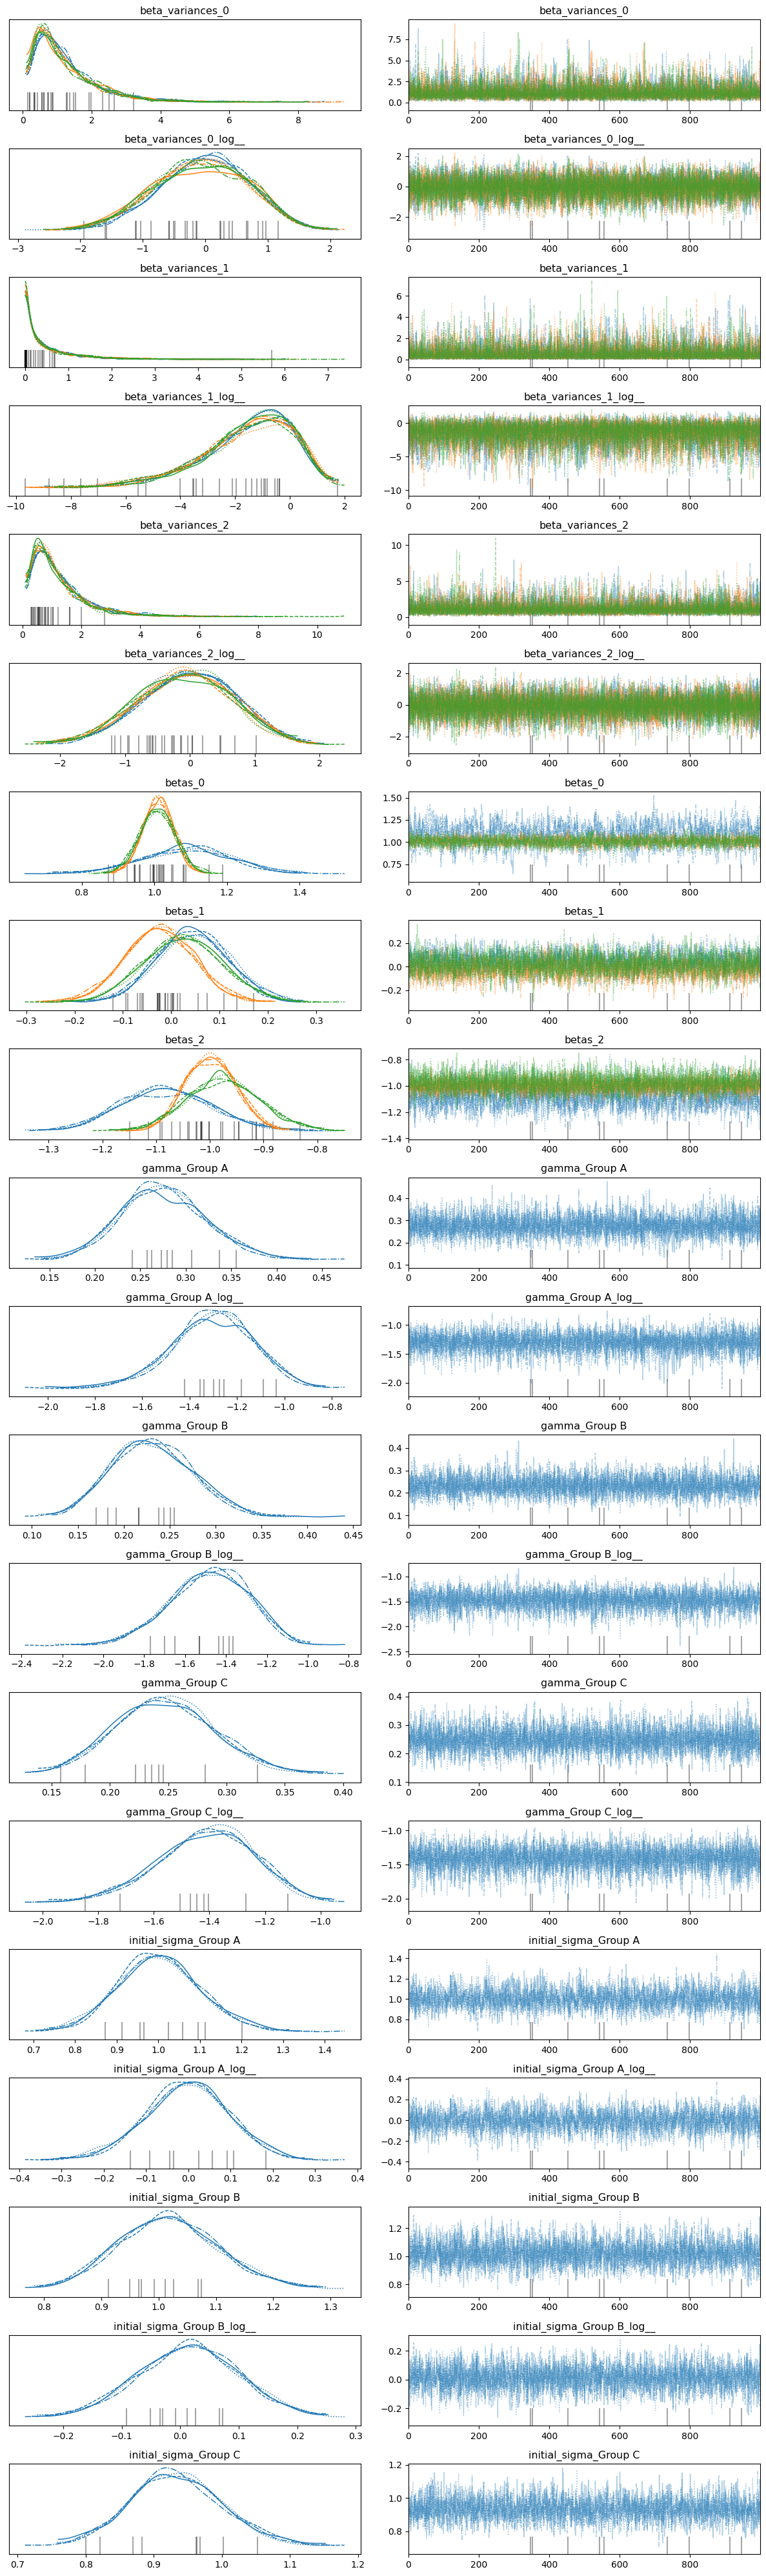

In [7]:
az.plot_trace(generalised_pareto_trace)
plt.tight_layout()

In [8]:
generalised_pareto_trace   

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).